In [1]:
# importing the libraries 
!pip install dask
!pip install pyarrow
!pip install plotly
import dask
import dask.dataframe as dd
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import os
import glob
import folium
import plotly.express as px
from dask.diagnostics import ProgressBar 
from collections import Counter
import warnings 
warnings.filterwarnings("ignore")

# 1. Dataset:
This dataset reflects reported incidents of crime (with the exception of murders where data exists for each victim) that occurred in the City of Chicago from 2005 to 2016. 

# 2. Variables of the dataset:

ID - Unique identifier for the record.

Case Number - The Chicago Police Department RD Number (Records Division Number), which is unique to the incident.

Date - Date when the incident occurred. this is sometimes a best estimate.

Block - The partially redacted address where the incident occurred, placing it on the same block as the actual address.

IUCR - The Illinois Unifrom Crime Reporting code. This is directly linked to the Primary Type and Description. See the list of IUCR codes at https://data.cityofchicago.org/d/c7ck-438e.

Primary Type - The primary description of the IUCR code.

Description - The secondary description of the IUCR code, a subcategory of the primary description.

Location Description - Description of the location where the incident occurred.

Arrest - Indicates whether an arrest was made.

Domestic - Indicates whether the incident was domestic-related as defined by the Illinois Domestic Violence Act.

Beat - Indicates the beat where the incident occurred. A beat is the smallest police geographic area – each beat has a dedicated police beat car. Three to five beats make up a police sector, and three sectors make up a police district. The Chicago Police Department has 22 police districts. See the beats at https://data.cityofchicago.org/d/aerh-rz74.

District - Indicates the police district where the incident occurred. See the districts at https://data.cityofchicago.org/d/fthy-xz3r.

Ward - The ward (City Council district) where the incident occurred. See the wards at https://data.cityofchicago.org/d/sp34-6z76.

Community Area - Indicates the community area where the incident occurred. Chicago has 77 community areas. See the community areas at https://data.cityofchicago.org/d/cauq-8yn6.

FBI Code - Indicates the crime classification as outlined in the FBI's National Incident-Based Reporting System (NIBRS). See the Chicago Police Department listing of these classifications at http://gis.chicagopolice.org/clearmap_crime_sums/crime_types.html.

X Coordinate - The x coordinate of the location where the incident occurred in State Plane Illinois East NAD 1983 projection. This location is shifted from the actual location for partial redaction but falls on the same block.

Y Coordinate - The y coordinate of the location where the incident occurred in State Plane Illinois East NAD 1983 projection. This location is shifted from the actual location for partial redaction but falls on the same block.

Year - Year the incident occurred.

Updated On - Date and time the record was last updated.

Latitude - The latitude of the location where the incident occurred. This location is shifted from the actual location for partial redaction but falls on the same block.

Longitude - The longitude of the location where the incident occurred. This location is shifted from the actual location for partial redaction but falls on the same block.

Location - The location where the incident occurred in a format that allows for creation of maps and other geographic operations on this data portal. This location is shifted from the actual location for partial redaction but falls on the same block.

# 3. Load data files:

In [2]:
#Loading the four CSV files
from glob import glob
filenames=sorted(glob(os.path.join("Data","*.csv")))
filenames

['Data/Chicago_Crimes_2005_to_2007.csv',
 'Data/Chicago_Crimes_2008_to_2011.csv',
 'Data/Chicago_Crimes_2012_to_2017.csv']

In [3]:
dask_all_file=dd.read_csv(filenames,error_bad_lines=False,assume_missing=True,dtype={'ID': np.int64,'PrimaryType': 'str','FBI Code': 'object','Beat': np.uint16,'IUCR': 'str','Latitude': 'object',
'Y Coordinate': 'object','Location': 'str'},  parse_dates=['Date'],infer_datetime_format=True)

# 4. Overview of dataset:

In [4]:
dask_all_file

,Unnamed: 0,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
npartitions=25,,,,,,,,,,,,,,,,,,,,,,,
,float64,int64,object,datetime64[ns],object,object,object,object,object,bool,bool,uint16,float64,float64,float64,object,float64,object,float64,object,object,float64,object
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [5]:
dask_all_file.dtypes

Unnamed: 0                     float64
ID                               int64
Case Number                     object
Date                    datetime64[ns]
Block                           object
IUCR                            object
Primary Type                    object
Description                     object
Location Description            object
Arrest                            bool
Domestic                          bool
Beat                            uint16
District                       float64
Ward                           float64
Community Area                 float64
FBI Code                        object
X Coordinate                   float64
Y Coordinate                    object
Year                           float64
Updated On                      object
Latitude                        object
Longitude                      float64
Location                        object
dtype: object

In [6]:
dask_all_file.head()

,Unnamed: 0,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,0.0,4673626,HM274058,2006-04-02 13:00:00,055XX N MANGO AVE,2825,OTHER OFFENSE,HARASSMENT BY TELEPHONE,RESIDENCE,False,...,45.0,11.0,26,1136872.0,1936499.0,2006.0,04/15/2016 08:55:02 AM,41.981912692,-87.771996,"(41.981912692, -87.771996382)"
1,1.0,4673627,HM202199,2006-02-26 13:40:48,065XX S RHODES AVE,2017,NARCOTICS,MANU/DELIVER:CRACK,SIDEWALK,True,...,20.0,42.0,18,1181027.0,1861693.0,2006.0,04/15/2016 08:55:02 AM,41.775732538,-87.611920,"(41.775732538, -87.611919814)"
2,2.0,4673628,HM113861,2006-01-08 23:16:00,013XX E 69TH ST,051A,ASSAULT,AGGRAVATED: HANDGUN,OTHER,False,...,5.0,69.0,04A,1186023.0,1859609.0,2006.0,04/15/2016 08:55:02 AM,41.769897392,-87.593671,"(41.769897392, -87.593670899)"
3,4.0,4673629,HM274049,2006-04-05 18:45:00,061XX W NEWPORT AVE,0460,BATTERY,SIMPLE,RESIDENCE,False,...,38.0,17.0,08B,1134772.0,1922299.0,2006.0,04/15/2016 08:55:02 AM,41.942984005,-87.780057,"(41.942984005, -87.780056951)"
4,5.0,4673630,HM187120,2006-02-17 21:03:14,037XX W 60TH ST,1811,NARCOTICS,POSS: CANNABIS 30GMS OR LESS,ALLEY,True,...,13.0,65.0,18,1152412.0,1864560.0,2006.0,04/15/2016 08:55:02 AM,41.784210853,-87.716745,"(41.784210853, -87.71674491)"


# 5. Data Cleaning:

## 5.1 Drop unwanted columns:

**We found the following columns not useful for our data analysis, so we decided to drop them.**

In [7]:
columns_to_drop = ['Unnamed: 0','ID','Case Number','IUCR','X Coordinate','Y Coordinate','Updated On','Location' ]
dask_all_file1 = dask_all_file.drop(columns_to_drop, axis=1)

In [8]:
dask_all_file1.columns

Index(['Date', 'Block', 'Primary Type', 'Description', 'Location Description',
       'Arrest', 'Domestic', 'Beat', 'District', 'Ward', 'Community Area',
       'FBI Code', 'Year', 'Latitude', 'Longitude'],
      dtype='object')

## 5.2 Persist DataFrame in memory:

**Persist is important because Dask DataFrame is lazy by default. It is often ideal to load, filter, and shuffle data once and keep this result in memory. Afterwards, each of the several complex queries can be based off of this in-memory data rather than have to repeat the full load-filter-shuffle process each time.**

*Source: "https://docs.dask.org/en/stable/dataframe-best-practices.html"*

In [9]:
%%time
with ProgressBar(): 
    dask_all_file1 = dask_all_file1.persist() # Persist the dataframe in memory

[                                        ] | 0% Completed |  2.9s

b'Skipping line 24743: expected 23 fields, saw 24\n'


[########                                ] | 20% Completed |  6min 59.0s

b'Skipping line 132222: expected 23 fields, saw 41\n'


[########################################] | 100% Completed | 14min 40.9s
CPU times: user 12min 54s, sys: 3min 22s, total: 16min 16s
Wall time: 14min 40s


## 5.3 Handle missing values:

In [10]:
missing_values = dask_all_file1.isnull().sum()
missing_values

Dask Series Structure:
npartitions=1
Arrest    int64
Year        ...
dtype: int64
Dask Name: dataframe-sum-agg, 76 tasks

In [11]:
missing_count = ((missing_values / dask_all_file1.index.size) * 100)
missing_count

Dask Series Structure:
npartitions=1
Arrest    float64
Year          ...
dtype: float64
Dask Name: mul, 129 tasks

In [12]:
%%time
with ProgressBar(): 
    missing_count_pct = missing_count.compute()
missing_count_pct

[########################################] | 100% Completed |  1.5s
CPU times: user 1.41 s, sys: 156 ms, total: 1.56 s
Wall time: 1.54 s


Date                    0.000000
Block                   0.000000
Primary Type            0.000000
Description             0.000000
Location Description    0.032803
Arrest                  0.000000
Domestic                0.000000
Beat                    0.000000
District                0.001479
Ward                    0.001529
Community Area          0.030643
FBI Code                0.000000
Year                    0.000000
Latitude                1.244349
Longitude               1.244349
dtype: float64

## 5.4 Drop rows with missing values:

**As we have around 8 million of records and percentage of missing in each column is extremely low (less than 10%), we decided to drop the missing instead of updating which is very expensive operation.**

In [13]:
%%time
rows_to_drop = list(missing_count_pct[(missing_count_pct > 0) & (missing_count_pct < 5)].index)
dask_all_file1 = dask_all_file1.dropna(subset=rows_to_drop)    

CPU times: user 15.6 ms, sys: 31.2 ms, total: 46.9 ms
Wall time: 25.7 ms


**Check after dropping missing**

In [14]:
missing_values = dask_all_file1.isnull().sum()
missing_values

Dask Series Structure:
npartitions=1
Arrest    int64
Year        ...
dtype: int64
Dask Name: dataframe-sum-agg, 101 tasks

In [15]:
missing_count = ((missing_values / dask_all_file1.index.size) * 100)
missing_count

Dask Series Structure:
npartitions=1
Arrest    float64
Year          ...
dtype: float64
Dask Name: mul, 154 tasks

In [16]:
%%time
with ProgressBar(): 
    missing_count_pct = missing_count.compute()
missing_count_pct

[########################################] | 100% Completed |  2.6s
CPU times: user 3.31 s, sys: 78.1 ms, total: 3.39 s
Wall time: 2.63 s


Date                    0.0
Block                   0.0
Primary Type            0.0
Description             0.0
Location Description    0.0
Arrest                  0.0
Domestic                0.0
Beat                    0.0
District                0.0
Ward                    0.0
Community Area          0.0
FBI Code                0.0
Year                    0.0
Latitude                0.0
Longitude               0.0
dtype: float64

## 5.5 Handle Duplicates

### 5.5.1 Drop duplicate records

In [17]:
%%time
dask_all_file1 = dask_all_file1.drop_duplicates()

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 19.7 ms


**Set Date as index**

In [18]:
%%time
with ProgressBar():
    dask_all_file1 = dask_all_file1.set_index('Date') 

[########################################] | 100% Completed | 29.0s
CPU times: user 33.8 s, sys: 13.3 s, total: 47 s
Wall time: 29.3 s


In [19]:
%%time
dask_all_file1.compute().info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4263777 entries, 2005-01-01 00:00:00 to 2017-01-18 10:12:00
Data columns (total 14 columns):
 #   Column                Dtype  
---  ------                -----  
 0   Block                 object 
 1   Primary Type          object 
 2   Description           object 
 3   Location Description  object 
 4   Arrest                bool   
 5   Domestic              bool   
 6   Beat                  uint16 
 7   District              float64
 8   Ward                  float64
 9   Community Area        float64
 10  FBI Code              object 
 11  Year                  float64
 12  Latitude              object 
 13  Longitude             float64
dtypes: bool(2), float64(5), object(6), uint16(1)
memory usage: 406.6+ MB
CPU times: user 32.9 s, sys: 12.2 s, total: 45.2 s
Wall time: 30.5 s


# 6. Writing to Parquet file and Loading DataFrame from Parquet file

**Dask DataFrame users are encouraged to store and load data using Parquet. Apache Parquet is a columnar binary format that is easy to split into multiple files (easier for parallel loading) and is generally much simpler to deal with.**

Source: https://docs.dask.org/en/stable/dataframe-best-practices.html

In [20]:
%%time
with ProgressBar():
    dask_all_file1.to_parquet('crimes-2005-2016.snappy.parq', compression='SNAPPY')

[########################################] | 100% Completed | 34.5s
CPU times: user 38.1 s, sys: 11.8 s, total: 49.9 s
Wall time: 35.4 s


In [91]:
%%time
crimes_df = dd.read_parquet('crimes-2005-2016.snappy.parq', index='Date')

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 10.2 ms


In [92]:
%%time
crimes_df = crimes_df.persist()

CPU times: user 3.69 s, sys: 2.3 s, total: 5.98 s
Wall time: 6.44 s


In [93]:
# dataframe structure
crimes_df

,Block,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,Year,Latitude,Longitude
npartitions=1,,,,,,,,,,,,,,
2005-01-01 00:00:00,object,object,object,object,bool,bool,uint16,float64,float64,float64,object,float64,object,float64
2017-01-18 10:12:00,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [94]:
%%time
crimes_df.head()

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 8.2 ms


,Block,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,Year,Latitude,Longitude
Date,,,,,,,,,,,,,,
2005-01-01,050XX W PATTERSON AVE,OTHER OFFENSE,HARASSMENT BY TELEPHONE,RESIDENCE,False,False,1634,16.0,38.0,15.0,26,2005.0,41.946964747,-87.753144
2005-01-01,047XX W CONGRESS PKWY,THEFT,FINANCIAL ID THEFT:$300 &UNDER,RESIDENCE,False,False,1131,11.0,24.0,25.0,06,2005.0,41.874125711,-87.743684
2005-01-01,030XX W FULTON BLVD,BURGLARY,FORCIBLE ENTRY,RESIDENCE,False,False,1331,12.0,27.0,27.0,05,2005.0,41.886474422,-87.701800
2005-01-01,058XX S NORDICA AVE,CRIMINAL DAMAGE,TO PROPERTY,RESIDENTIAL YARD (FRONT/BACK),False,False,811,8.0,23.0,56.0,14,2005.0,41.78581508,-87.797485
2005-01-01,073XX N DAMEN AVE,OTHER OFFENSE,VIOLATE ORDER OF PROTECTION,RESIDENCE,True,True,2424,24.0,49.0,1.0,26,2005.0,42.014842024,-87.680487


# 7. Data Analysis and Visualization:

## 7.1 Top 10 Years with highest crime records

In [98]:
crime_by_year=crimes_df.groupby([crimes_df.index.year]).size().compute()
        
top_10_years = crime_by_year.nlargest(10).sort_values(axis=0,ascending=False)
top_10_years

Date
2005    448196
2006    443504
2007    434158
2008    418947
2009    385174
2010    367797
2011    349917
2012    333872
2013    303730
2014    268947
dtype: int64

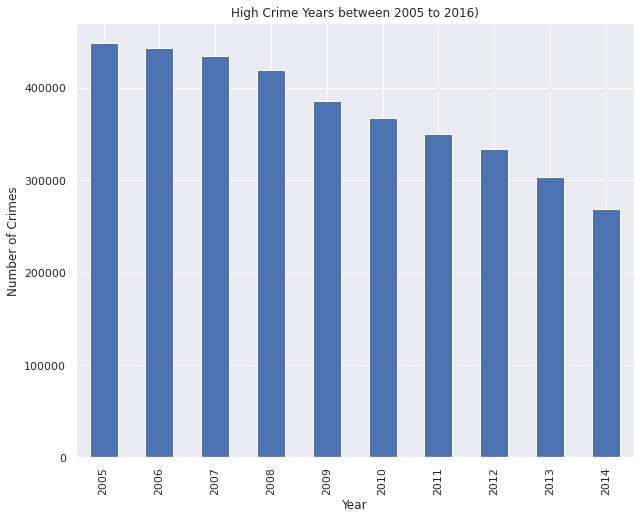

In [101]:
# Top 10 high crime years
top_10_years.plot(kind='bar', figsize=(10,8))
plt.title('High Crime Years between 2005 to 2016)')
plt.xlabel('Year')
plt.ylabel('Number of Crimes')
plt.show()

**2005 we see the highest crimes reported**

## 7.2. Top 10 of most violent community area

In [96]:
%%time
# upload the community file
community_areas = pd.read_csv('chicago-community-areas.csv')
# apply groupby function and calculate the amount of crime, rename to Total
community_areas['Total'] = crimes_df.groupby('Community Area').size().compute().rename('Total')
# sort value
community_crime = community_areas.sort_values(by='Total', ascending=False).dropna()
# drop unused columns and reindex
community_crime = community_crime.drop(['CommunityArea','Side'], axis=1)
community_crime = community_crime.set_index('CommunityName')
# top 10 of most violent community area
community_crime.nlargest(10,'Total')

CPU times: user 62.5 ms, sys: 2.14 s, total: 2.2 s
Wall time: 2.27 s


,Total
CommunityName,
Austin,276375
South Shore,142048
Near North Side,139191
Humboldt Park,135257
West Englewood,127218
Auburn Gresham,123574
West Town,123068
North Lawndale,122176
Near West Side,119817


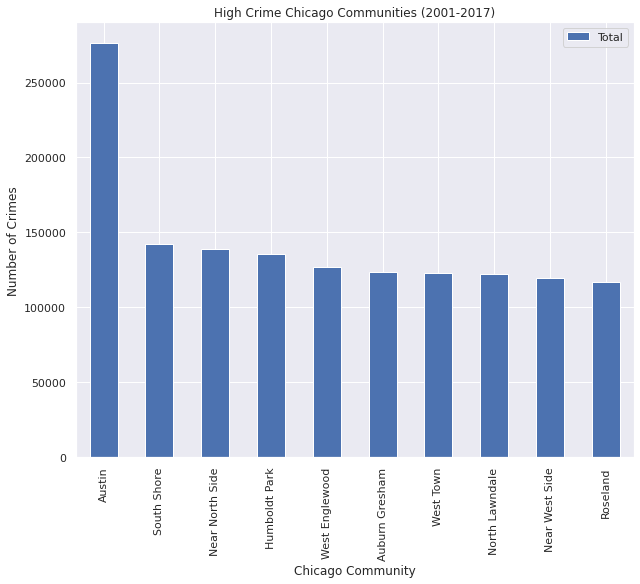

In [97]:
# Top 10 high crime communities
community_crime.nlargest(10,'Total').plot(kind='bar', figsize=(10,8))
plt.title('High Crime Chicago Communities (2001-2017)')
plt.xlabel('Chicago Community')
plt.ylabel('Number of Crimes')
plt.show()

**Austin is the highest crime community area in Chicago as per the above chart.**

## 7.3. Count of Arrest, domestic and total crimes group by crime types

In [29]:
%%time
# get crime types
crime_types = crimes_df[['Primary Type']]

# get crime counts by primary type
crime_type_total = crimes_df.groupby('Primary Type').size().compute()

# get arrests and domestic counts for each primary crime type
crime_type_counts = crimes_df[['Primary Type', 'Arrest', 'Domestic']].groupby('Primary Type').sum().compute()

# add crime type totals column
crime_type_counts['Total'] = crime_type_total

# print all crimes (arrests, domestic, and totals)
print(crime_type_counts.sort_values(by='Total', ascending=False))

                                   Arrest  Domestic   Total
Primary Type                                               
THEFT                              102482     21787  891547
BATTERY                            178020    341020  770855
CRIMINAL DAMAGE                     34015     38299  493515
NARCOTICS                          458495       184  462487
BURGLARY                            14499      1703  260876
OTHER OFFENSE                       45170     78580  260054
ASSAULT                             61718     56589  258235
MOTOR VEHICLE THEFT                 15074       965  194550
ROBBERY                             16307      2463  164055
DECEPTIVE PRACTICE                  26534      1785  159178
CRIMINAL TRESPASS                   88584      3961  122021
WEAPONS VIOLATION                   35077       135   43842
PROSTITUTION                        39672         3   39922
PUBLIC PEACE VIOLATION              24683      1350   34810
OFFENSE INVOLVING CHILDREN           555

## 7.4. Plot crimes by primary type counts

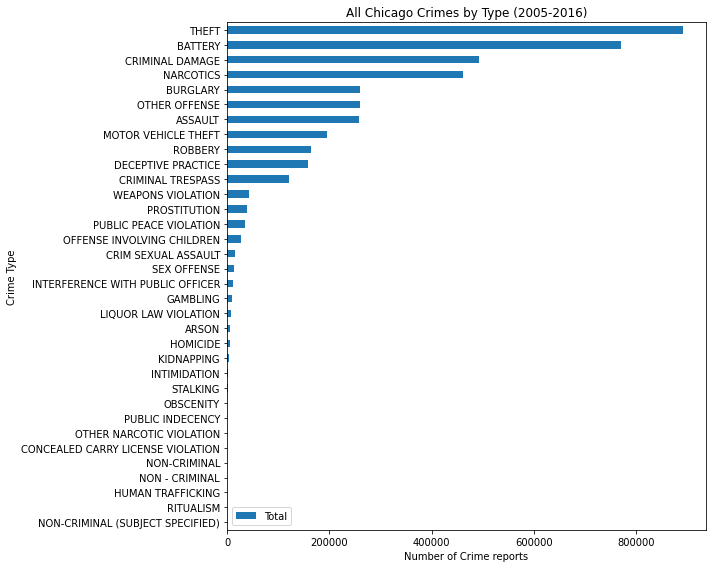

CPU times: user 703 ms, sys: 281 ms, total: 984 ms
Wall time: 413 ms


In [30]:
%%time
all_crime_types = crime_type_counts.sort_values(by='Total', ascending=True).drop(['Arrest', 'Domestic'], axis=1) # denotes column
all_crime_types.plot(kind='barh', figsize=(10,8))
plt.title('All Chicago Crimes by Type (2005-2016)')
plt.xlabel('Number of Crime reports')
plt.ylabel('Crime Type')
plt.tight_layout()
plt.show()

**Theft is the most common crime type in Chicago.**

## 7.5. Top 10 types of crimes and their number of occurences

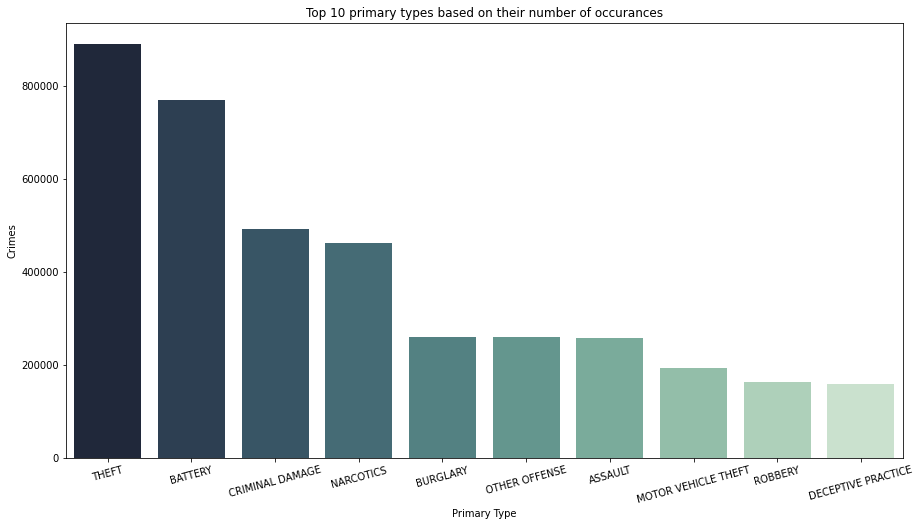

CPU times: user 734 ms, sys: 219 ms, total: 953 ms
Wall time: 647 ms


In [31]:
%%time
Prim_Type = crimes_df["Primary Type"]
Prim_Type2 = Counter(Prim_Type)
Top_Prim_Type = Prim_Type2.most_common(10)
x,y = zip(*Top_Prim_Type)
x,y  = list(x),list(y)
plt.figure(figsize=(15,8))
ax = sns.barplot(x=x, y=y, palette = sns.cubehelix_palette(len(x), rot=-.4, reverse=True))
plt.xticks(rotation= 15)
plt.title("Top 10 primary types based on their number of occurances")
plt.xlabel("Primary Type")
plt.ylabel("Crimes")
plt.show()

**Top 10 types of crimes are Theft, Battery, Criminal damage, Narcotics, Burglary, Other Offense, Assault, Motor Vehicle Theft , Robbery and Deceptive Practice**

### Closer look at the Theft crimes:

In [107]:
%%time
Theft_Crimes = crimes_df[crimes_df['Primary Type']== "THEFT"]
Theft_Crimes_details = Theft_Crimes[['Primary Type', 'Description']].groupby('Description').count().compute().sort_values(by='Primary Type', ascending=False)
Theft_Crimes_details.head()

CPU times: user 406 ms, sys: 78.1 ms, total: 484 ms
Wall time: 602 ms


,Primary Type
Description,
$500 AND UNDER,314692
OVER $500,216373
FROM BUILDING,159521
RETAIL THEFT,115633
FINANCIAL ID THEFT: OVER $300,27687


**Most of the theft reported cases are '$500 and under' description.**

## 7.6. Plot top crimes (>= 200,000 reports)

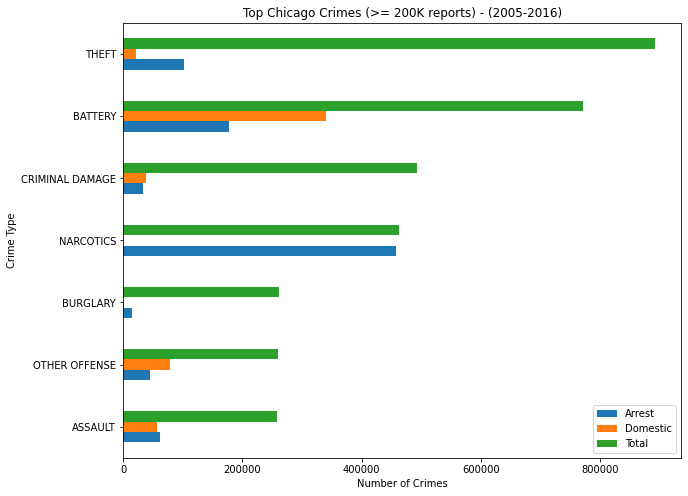

CPU times: user 391 ms, sys: 125 ms, total: 516 ms
Wall time: 242 ms


In [33]:
%%time
crime_type_counts[crime_type_counts['Total'] >= 200000].sort_values(by='Total', ascending=True).plot(kind='barh', figsize=(10,8))
plt.title('Top Chicago Crimes (>= 200K reports) - (2005-2016)')
plt.xlabel('Number of Crimes')
plt.ylabel('Crime Type')
plt.show()

**Above graph depicts that in Narcotics related crimes, the arrest rate is very high.**

## 7.7. Top 10 locations by no. of crimes (Based on Location Description)

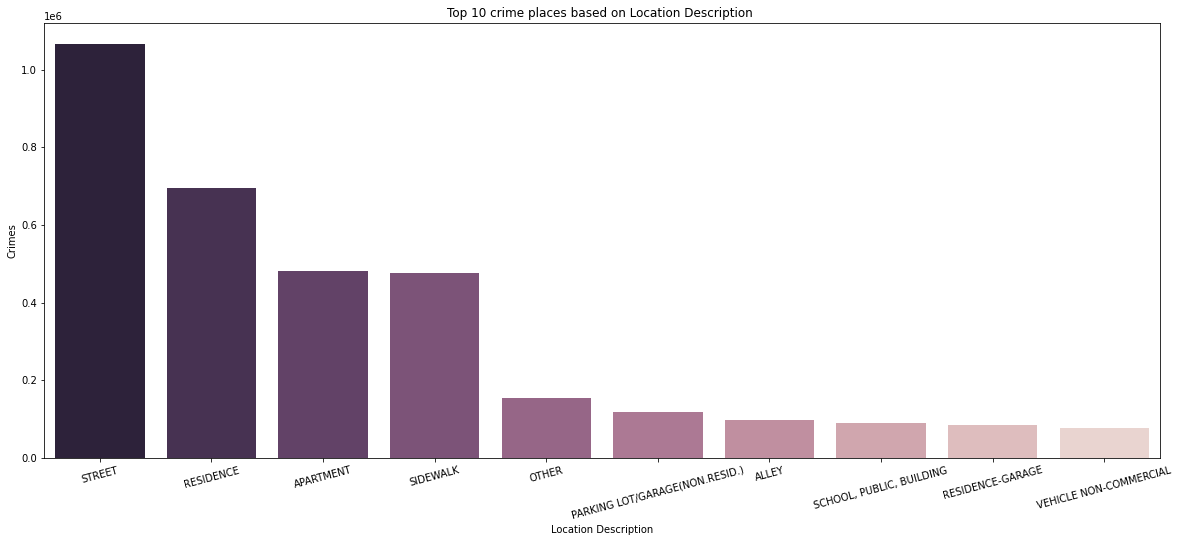

CPU times: user 859 ms, sys: 203 ms, total: 1.06 s
Wall time: 742 ms


In [34]:
%%time
Loc_Desc = crimes_df["Location Description"]
counted = Counter(Loc_Desc) 
top_Loc_Desc = counted.most_common(10)
x,y = zip(*top_Loc_Desc)
x,y = list(x),list(y)
plt.figure(figsize = (20,8))
ax = sns.barplot(x = x , y = y, palette = sns.cubehelix_palette(len(x), reverse=True))
plt.xticks(rotation= 15)
plt.xlabel("Location Description")
plt.ylabel("Crimes")
plt.title("Top 10 crime places based on Location Description ")
plt.show()

**The most common crime location is Chicago streets.**

## 7.8. Get 'other offenses' crimes

In [35]:
%%time
other_offenses = crimes_df[crimes_df['Primary Type']=='OTHER OFFENSE']
other_offense_crimes = other_offenses[['Primary Type', 'Description']].groupby('Description').count().compute().sort_values(by='Primary Type', ascending=False)
other_offense_crimes.head(10)

CPU times: user 312 ms, sys: 93.8 ms, total: 406 ms
Wall time: 410 ms


,Primary Type
Description,
TELEPHONE THREAT,85712
HARASSMENT BY TELEPHONE,59052
VIOLATE ORDER OF PROTECTION,20191
OTHER VEHICLE OFFENSE,19460
HARASSMENT BY ELECTRONIC MEANS,17370
FALSE/STOLEN/ALTERED TRP,14351
OTHER WEAPONS VIOLATION,6442
VEHICLE TITLE/REG OFFENSE,4965
OTHER CRIME INVOLVING PROPERTY,4863


## 7.9. Plot top 20 other offense crimes

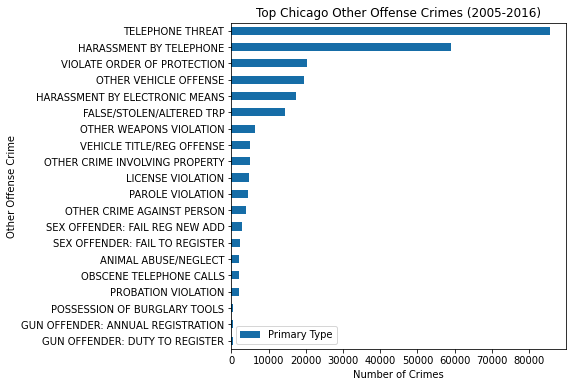

CPU times: user 422 ms, sys: 188 ms, total: 609 ms
Wall time: 329 ms


In [36]:
%%time
other_offense_crimes[:20].sort_values(by='Primary Type', ascending=True).plot(kind='barh', figsize=(6,6), color='#166DA7')
plt.title('Top Chicago Other Offense Crimes (2005-2016)')
plt.xlabel('Number of Crimes')
plt.ylabel('Other Offense Crime')
plt.show()

## 7.10. Comparing Arrested or Not

In [37]:
Arrest = crimes_df["Arrest"]
Arrest2 = Counter(Arrest)
MostCommonCA = Arrest2.most_common()
x,y = zip(*MostCommonCA)
x,y = list(x),list(y)
x,y

([False, True], [3078389, 1185388])

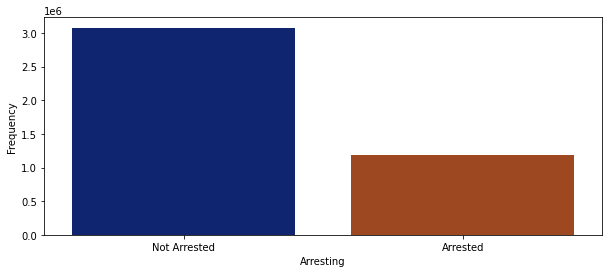

CPU times: user 188 ms, sys: 156 ms, total: 344 ms
Wall time: 142 ms


In [38]:
%%time
x[1] = "Arrested"
x[0] = "Not Arrested" 
plt.figure(figsize=(10,4))
sns.barplot(x = x , y = y , palette = "dark")
plt.xlabel("Arresting")
plt.ylabel("Frequency")
plt.show()

## 7.11. Plot Arrested Rate

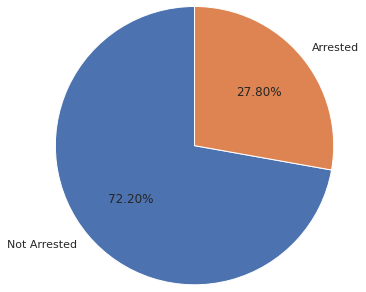

CPU times: user 62.5 ms, sys: 31.2 ms, total: 93.8 ms
Wall time: 83.8 ms


In [71]:
%%time
plt.pie(y,
        labels = x, 
        autopct = "%0.2f%%", # Show data in percentage with 2 decimal point
        startangle = 90,
        radius = 1.6
         )
plt.show()

**Very few crime reports (~27.80%) end up in an arrest.**

## 7.12. Arrested rate per crime

In [40]:
%%time
rate_per_crime = crimes_df.groupby('Primary Type')['Arrest'].mean().reset_index()
rate_per_crime['Arrest (%)'] = rate_per_crime['Arrest'].round(4)*100
rate_per_crime.head(20)

CPU times: user 531 ms, sys: 266 ms, total: 797 ms
Wall time: 842 ms


,Primary Type,Arrest,Arrest (%)
0,ARSON,0.119355,11.94
1,ASSAULT,0.238999,23.90
2,BATTERY,0.230938,23.09
3,BURGLARY,0.055578,5.56
4,CONCEALED CARRY LICENSE VIOLATION,0.857143,85.71
5,CRIM SEXUAL ASSAULT,0.144369,14.44
6,CRIMINAL DAMAGE,0.068924,6.89
7,CRIMINAL TRESPASS,0.725973,72.60
8,DECEPTIVE PRACTICE,0.166694,16.67
9,GAMBLING,0.991265,99.13


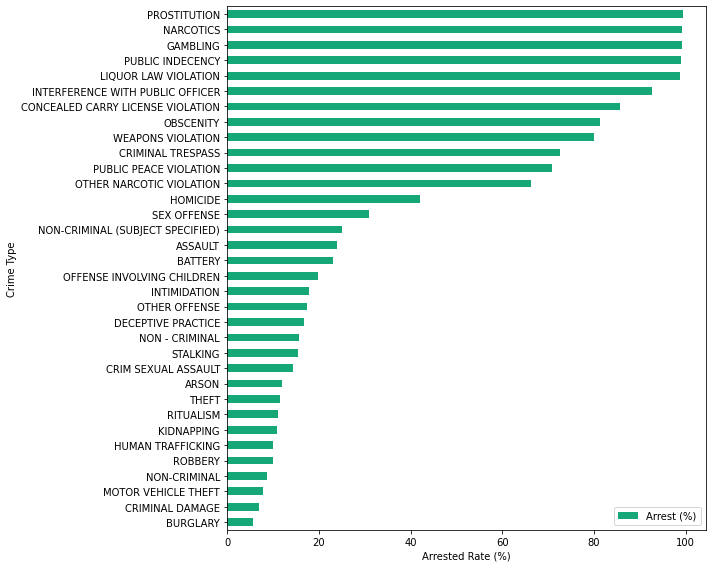

CPU times: user 1.28 s, sys: 406 ms, total: 1.69 s
Wall time: 895 ms


In [41]:
%%time
rate_per_crime = rate_per_crime.compute()
rate_per_crime = rate_per_crime.sort_values(by='Arrest (%)', ascending=True).drop(['Arrest'], axis=1) # denotes column
rate_per_crime.plot(x="Primary Type", y="Arrest (%)", kind='barh', figsize=(10,8), color='#16A778')
plt.xlabel('Arrested Rate (%)')
plt.ylabel('Crime Type')
plt.tight_layout()
plt.show()

**Even if Theft is the most common crime in Chicago but Arrest rate is quite low comparatively.**

## 7.13. Plot crimes per day of the week

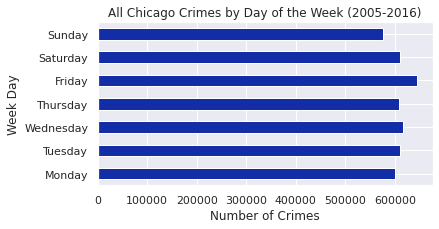

CPU times: user 797 ms, sys: 219 ms, total: 1.02 s
Wall time: 705 ms


In [52]:
%%time
crimes_df = crimes_df.compute()
days = ['Monday','Tuesday','Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
crimes_df2 = crimes_df.groupby([crimes_df.index.dayofweek]).size()
crimes_df2.plot(kind='barh', figsize=(6,3), color='#132DA6')
plt.title('All Chicago Crimes by Day of the Week (2005-2016)')
plt.xlabel('Number of Crimes')
plt.ylabel('Week Day')
plt.yticks(np.arange(7), days)
plt.show()

**We can easily infer from the above graph that Fridays the criminal activities are at their highest. So, accordingly Police department can have more patrolling and preventive measures on Fridays to have a check on them.**

## 7.14. Plot crimes per month of the year

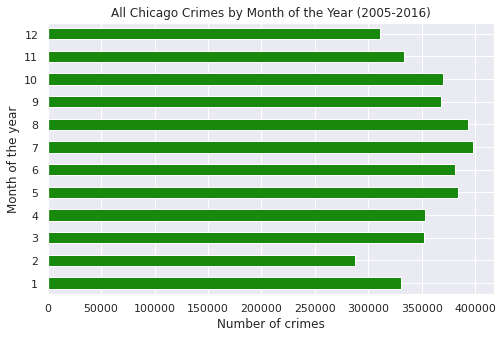

CPU times: user 797 ms, sys: 234 ms, total: 1.03 s
Wall time: 727 ms


In [64]:
%%time
crimes_df.groupby([crimes_df.index.month]).size().plot(kind='barh', figsize=(8,5), color='#19890D')
plt.title('All Chicago Crimes by Month of the Year (2005-2016)')
plt.xlabel('Number of crimes')
plt.ylabel('Month of the year')
plt.show()

**We can see clearly in the graph that the peak of the crimes is during summer(July) across all these years.**

## 7.15. Sum of all crimes through the years

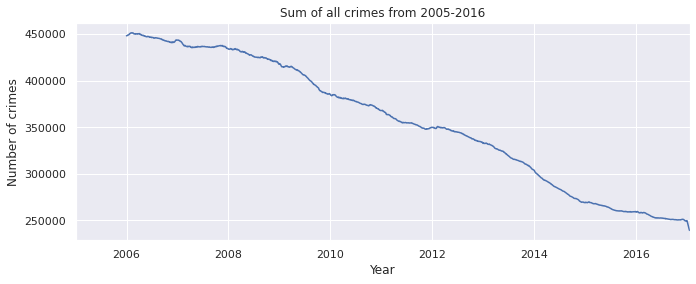

In [65]:
plt.figure(figsize=(11,4))
crimes_df.resample('D').size().rolling(365).sum().plot()
plt.title('Sum of all crimes from 2005-2016')
plt.ylabel('Number of crimes')
plt.xlabel('Year')
plt.show()

**Number of crimes reported has declined over the period of 10 year from 2006 to 2016.**

## 7.16. Mapping Theft Crime Locations

In [57]:
Theft_Crimes = crimes_df.drop(columns=['Block', 'Domestic', 'Beat', 'District', 'Ward', 'FBI Code'], axis = 1)
Theft_Crimes = Theft_Crimes[Theft_Crimes["Primary Type"] == "THEFT"]
Theft_Crimes.head()

,Primary Type,Description,Location Description,Arrest,Community Area,Year,Latitude,Longitude
Date,,,,,,,,
2005-01-01,THEFT,FINANCIAL ID THEFT:$300 &UNDER,RESIDENCE,False,25.0,2005.0,41.874125711,-87.743684
2005-01-01,THEFT,FINANCIAL ID THEFT: OVER $300,RESIDENCE,False,68.0,2005.0,41.782646487,-87.636096
2005-01-01,THEFT,FINANCIAL ID THEFT: OVER $300,RESIDENCE,False,44.0,2005.0,41.743592217,-87.628425
2005-01-01,THEFT,FINANCIAL ID THEFT: OVER $300,RESIDENCE,False,68.0,2005.0,41.771199121,-87.637302
2005-01-01,THEFT,FINANCIAL ID THEFT: OVER $300,RESIDENCE,False,34.0,2005.0,41.843074007,-87.631807


In [58]:
locations = Theft_Crimes.groupby('Community Area').first()
new_locations = locations.loc[:, ['Latitude', 'Longitude']]
new_locations.head()

,Latitude,Longitude
Community Area,,
0.0,41.970514812,-87.836651
1.0,42.004480111,-87.664305
2.0,41.996928759,-87.687417
3.0,41.967860872,-87.674146
4.0,41.979480037,-87.697539


In [60]:
MapOfChicago = folium.Map(location=[41.881832, -87.623177], zoom_start=11)
i=0
for index, row in new_locations.iterrows():
    folium.Marker(location = [row['Latitude'], row['Longitude']]).add_to(MapOfChicago)

MapOfChicago

**Theft is prevalent across entire Chicago.**

## 7.17. Summary: Overall number of cases per Year x Months using Heatmap

In [61]:
crimes_df2 = pd.DataFrame(crimes_df.resample("M").size(), columns=["Number of cases"])
crimes_df2["Month"] = crimes_df2.index.month.astype(str)
crimes_df2["Year"] = crimes_df2.index.year.astype(str)
crimes_df2["Year-Month"] = crimes_df2["Year"].str.cat(crimes_df2["Month"].str.zfill(2), sep="-")
crimes_df2.head()

,Number of cases,Month,Year,Year-Month
Date,,,,
2005-01-31,33249,1,2005,2005-01
2005-02-28,31559,2,2005,2005-02
2005-03-31,36449,3,2005,2005-03
2005-04-30,38453,4,2005,2005-04
2005-05-31,40137,5,2005,2005-05


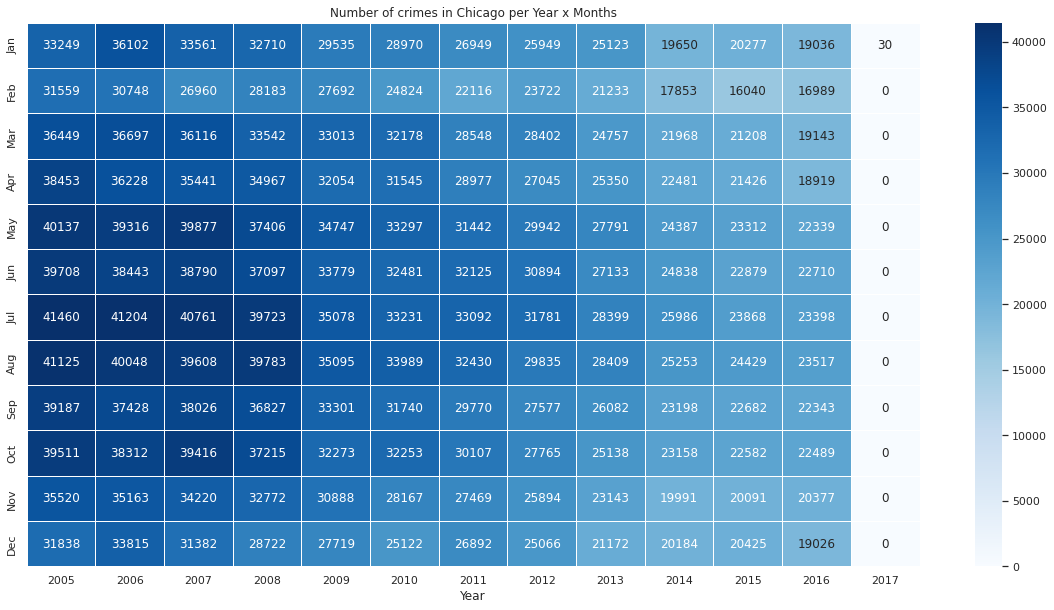

In [63]:
crimes_df3 = crimes_df2[["Month", "Year", "Number of cases"]]
crimes_df3 = crimes_df3.pivot("Month", "Year", "Number of cases").fillna(0).astype(int)
crimes_df3.index = crimes_df3.index.astype(int)
crimes_df3 = crimes_df3.sort_index()
crimes_df3.index = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.figure(figsize=(20, 10))
_ = sns.heatmap(
    crimes_df3,
    annot=True,
    fmt="d",
    linewidths=0.5,
    cmap="Blues",
).set_title('Number of crimes in Chicago per Year x Months')

**The years between 2005 and 2008 were a tough time**

# 8. Conclusion:

* Theft is the most common crime in Chicago. Most of the theft reported cases are with '$500 and under' description.
* Top 10 types of crimes are Theft, Battery, Criminal damage, Narcotics, Burglary, Other Offense, Assault, Motor Vehicle Theft , Robbery and Deceptive Practice
* The most common crime location is Chicago streets.
* We see the highest crimes reported in 2005.
* Austin is the highest crime community area in Chicago as per our analysis.
* Very few crime reports (~27.80%) end up in an arrest. But we found that in Narcotics related crimes, the arrest rate is very high almost 100%.
* Even if Theft is the most common crime in Chicago but Arrest rate is quite low comparatively.
* We can easily infer from the above graph that Fridays the criminal activities are at their highest. So, accordingly Police department can have more patrolling and preventive measures on Fridays to have   a check on them.
* We can see clearly in the graph that the peak of the crimes is during summer(July) across all these years.
* Number of crimes reported has declined over the period of 10 year from 2006 to 2016.
* The years between 2005 and 2008 were a tough time in Chicago considering the criminal activities.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=6ab987db-b709-4ef7-9bee-384a40c4b1c2' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>